In [1]:
import pickle

from embeddings.embedding_utils import get_queries, get_query_key
from clustering.clusterings import kmeans_with_estimated_k,xmeans_clustering, hdbscan_clustering, agglomerative_clustering_with_estimated_k
from matplotlib import pyplot as plt
from embeddings.tf_idf import get_embedding_pca
from embeddings.fasttext import get_embedding_combined_polling_pca
from embeddings.openai_api import get_embedding as embedding_openai
import seaborn as sns
import matplotlib.ticker as ticker
import numpy as np

In [3]:
data_queries = get_queries()
embedding_algo = embedding_openai
embeddings_display_name="OpenAI"
cluster_algos = [xmeans_clustering, hdbscan_clustering, agglomerative_clustering_with_estimated_k]
cluster_algo_display_names=["X-Means", "HDBSCAN","Agglomerative Clustering"]


for dataset_diff in ["easy", "medium", "hard"]:
    cluster_sizes = []
    for i, cluster_algo in enumerate(cluster_algos):
        cluster_algo_name=cluster_algo.__name__
        cluster_algo_display_name=cluster_algo_display_names[i]

        embedding_algo_name=embedding_algo.__module__.split(".")[-1]+"__"+embedding_algo.__name__
        embedding_display_name = "OpenAI"

        file=f"{embedding_algo_name}/{cluster_algo_name}/{dataset_diff}.pkl"
        with open(file, "rb") as f:
            data_dict = pickle.load(f)
        cluster_labels = data_dict["clusters"]
        print(f"total amount of datapoints: {len(cluster_labels)}, for dataset {dataset_diff}")

        num_of_clusters = len(set(cluster_labels) - {-1})
        cluster_sizes.append(str(num_of_clusters))
    print(f"{dataset_diff} & "+' & '.join(cluster_sizes))





total amount of datapoints: 4015, for dataset easy
total amount of datapoints: 4015, for dataset easy
total amount of datapoints: 4015, for dataset easy
easy & 17 & 154 & 15
total amount of datapoints: 3956, for dataset medium
total amount of datapoints: 3956, for dataset medium
total amount of datapoints: 3956, for dataset medium
medium & 15 & 172 & 15
total amount of datapoints: 3668, for dataset hard
total amount of datapoints: 3668, for dataset hard
total amount of datapoints: 3668, for dataset hard
hard & 13 & 152 & 15


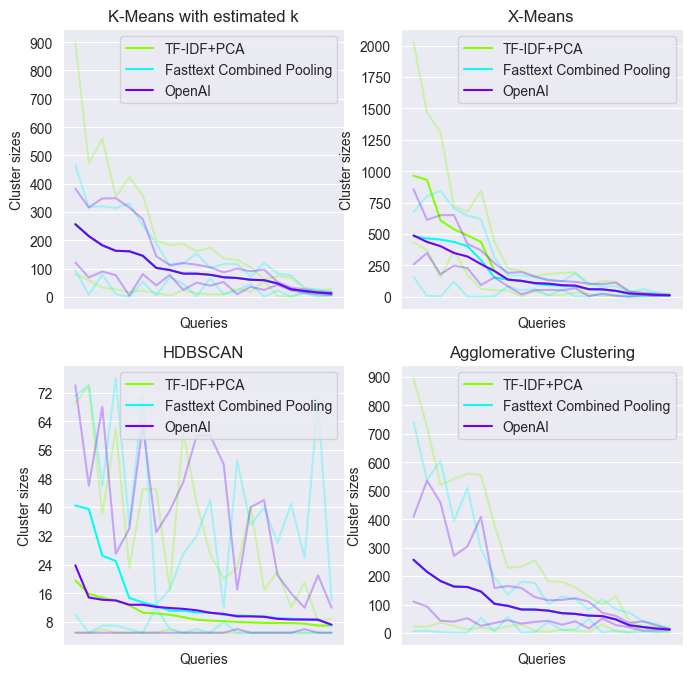

In [4]:
from collections import Counter
fig, axs = plt.subplots(2,2, figsize=(8,8))

for i, cluster_algo in enumerate(cluster_algos):
    ax = axs[i//2,i%2]
    cluster_algo_name=cluster_algo.__name__
    cluster_algo_display_name=cluster_algo_display_names[i]
    colors = sns.color_palette("hsv", len(embeddings))


    ax.title.set_text(cluster_algo_display_name)
    ax.set_ylabel("Cluster sizes")
    ax.set_xlabel("Queries")
    ax.xaxis.set_ticks([])
    ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    for j, embedding_algo in enumerate(embeddings):
        embedding_algo_name=embedding_algo.__module__.split(".")[-1]+"__"+embedding_algo.__name__
        embedding_display_name = embeddings_display_names[j]
        cluster_sizes_all = []

        for category in data_queries.keys():
            for query in data_queries[category]:
                query_key = get_query_key(category, query)
                file=f"{embedding_algo_name}/{cluster_algo_name}/{query_key}.pkl"
                with open(file, "rb") as f:
                    data_dict = pickle.load(f)
                cluster_labels = data_dict["clusters"]
                counter = Counter(cluster_labels)
                cluster_sizes = [size for label, size in counter.items() if label != -1]
                if len(cluster_sizes) == 0:
                    cluster_sizes = [0]
                cluster_sizes_all.append(cluster_sizes)
        cluster_sizes_max = np.array([max(cluster_sizes) for cluster_sizes in cluster_sizes_all])
        cluster_sizes_min = np.array([min(cluster_sizes) for cluster_sizes in cluster_sizes_all])
        cluster_sizes_mean = np.array([sum(cluster_sizes)/len(cluster_sizes) for cluster_sizes in cluster_sizes_all])
        # sort all by max
        sort = np.argsort(cluster_sizes_mean)[::-1]
        cluster_sizes_max = cluster_sizes_max[sort]
        cluster_sizes_min = cluster_sizes_min[sort]
        cluster_sizes_mean = cluster_sizes_mean[sort]

        ax.plot(cluster_sizes_max, color=colors[j], alpha=0.3)
        ax.plot(cluster_sizes_min, color=colors[j], alpha=0.3)
        ax.plot(cluster_sizes_mean, color=colors[j], label=embedding_display_name)

    ax.legend()

plt.savefig("cluster_sizes.png")
plt.show()

